# Assignment 5: GMM  Soft Allocation
 

In [1]:
#Libraries required for my code to run

#Uncomment this if you want to display your [graphs] within the notebook in a proper format.
%matplotlib inline
#Uncomment this if you want to display your graphs in backend


import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 
from pandas import DataFrame
import pandas as pd
import numpy as np
from numpy.random import randn
import glob
import sys

import warnings
warnings.filterwarnings('ignore')


1.Synthetic Data Generation first method

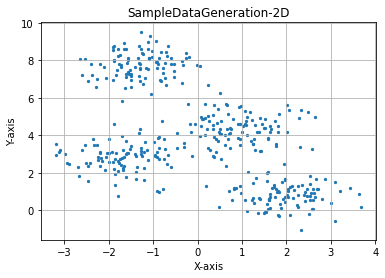

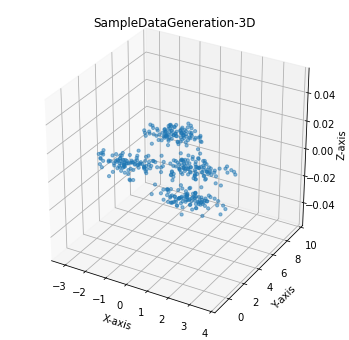

Text(0.5, 1.0, 'Histogram')

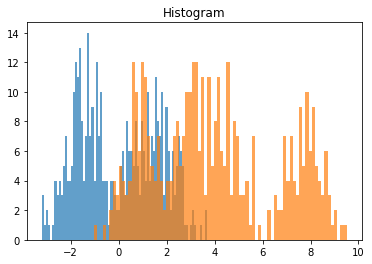

In [2]:
#Synthetic Data Generation first method

K=4 # Step1:Choose the Number of clusters
#%matplotlib
from sklearn.datasets.samples_generator import make_blobs
Data, y_true = make_blobs(n_samples=400, centers=K,
                       cluster_std=0.70, random_state=0)

df = pd.DataFrame(data=Data, columns=["X", "Y"])
#Plot 2D

plt.scatter(Data[:, 0], Data[:, 1], s=5)

plt.title("SampleDataGeneration-2D")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.grid()
#plt.scatter(centers[:, 0], centers[:, 1],c='red', s=50)
#plt.title("SampleDataGeneration-2D")
#plt.xlabel("X-axis")
#plt.ylabel("Y-axis")
#plt.grid()

#3D Plot
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Data[:, 0],Data[:, 1],
           linewidths=1, alpha=0.5,
           #edgecolor='k',
           s =10,
           )
ax.set_title("SampleDataGeneration-3D")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()


def plot_hist(data):
    for x in data:
        plt.hist(x, bins = 80, alpha = 0.7)

plot_hist([Data[:, 0], Data[:, 1]])
plt.title("Histogram")

In [3]:
from scipy.stats import multivariate_normal
X=Data


class GaussianMixture():
    #Here you will create a refernce to all the parameters which gets substituted against declared variables
    def __init__(self, gaussians: int, n_iters: int, tol: float, seed: int):
        self.gaussians = gaussians
        self.n_iters = n_iters
        self.tol = tol
        self.seed = seed

    def fit(self, X):

        # data's dimensionality and probability vector initialization
        self.n_row, self.n_col = X.shape     
        self.probability = np.zeros((self.n_row, self.gaussians))
        
        #print(self.probability)
        
        ##Below multicommented block can be used if you want to apply GMM on a dataset without Kmeans result
        
       
        # initialize parameters
        np.random.seed(self.seed)
        chosen = np.random.choice(self.n_row, self.gaussians, replace = False)
        #print("Chosen:",chosen)
        self.means = X[chosen]
        #print("Initial Means:",self.means)
        self.weights = np.full(self.gaussians, 1 / self.gaussians)
        #print("Initial weights:",self.weights)
        
        # for np.cov, rowvar = False, 
        # indicates that the rows represents obervation
        shape = self.gaussians, self.n_col, self.n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))
       # print("Initial Covariance:",self.covs)
        """
        self.means=m
        self.weights=pi
        self.covs=c
        """

        log_likelihood = 0 #Initializing for iteration
        self.converged = False
        self.log_likelihood_trace = []      
        print("...Entering GMM Clustering...\n")
        for i in range(self.n_iters):
            
            log_likelihood_new = self.Estep(X)
            self.Mstep(X)
            

            if  (abs(log_likelihood_new - log_likelihood) <= self.tol):
                
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)
            print("Iteration: ",i,"  log_likelihood: ", log_likelihood)
        
        plt.plot(self.log_likelihood_trace)
        plt.title("Loglikelihood Convergence Graph")
        
        
        #print("log_likelihood_trace:",self.log_likelihood_trace)
        last=self.log_likelihood_trace[-1]
        #print(last)

        return self.means,self.weights,self.covs,self.probability

    def Estep(self, X):
        """
        E-step: compute probability,
        update probability matrix so that probability[i, j] is the probability of cluster k 
        for data point i,
        to compute likelihood of data point i belonging to given cluster k, 
        use multivariate_normal.pdf
        """
        self._compute_log_likelihood(X)
        
        self.log_likelihood1 = np.sum(np.log(np.sum(self.probability, axis = 1)))
        
         #Normalization       
        self.probability = self.probability / self.probability.sum(axis = 1, keepdims = 1)
        #print("Normalised probability",self.probability)
        return self.log_likelihood1

    def _compute_log_likelihood(self, X):
        for k in range(self.gaussians):
            
                prior = self.weights[k]
                #print("prior_weight",prior)
                likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
                #print("Likelihood/probability"+str(k),likelihood)
                self.probability[:, k] = prior * likelihood
                #print(" Size of Initial Probability of all the datapoints in cluster"+str(k),self.probability.shape)          

        return self



    def compute_log_likelihood(self, X):
        self.probs = np.zeros((X.shape[0] , self.gaussians))
        
        for k in range(self.gaussians):

            prior = self.weights[k]            
            #print("prior_weight",prior)
            self.likeli = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            #print("Likelihood/probability"+str(k),likelihood)

            self.probs[:,k]= prior * self.likeli
            #print(" Size of Initial Probability of all the datapoints in cluster"+str(k),self.probability.shape)       

        self.probs = self.probs / (np.sum(self.probs, axis=1)[:, np.newaxis])
        
        return self.probs



    def compute_log_likelihood_newmean(self, X, nmean, nvar, nweights):
        self.probs1 = np.zeros((X.shape[0], self.gaussians))
        
        for k in range(self.gaussians):

            prior = nweights[k]
            #print("prior_weight",prior)
            self.likeli = multivariate_normal(nmean[k], nvar[k]).pdf(X)
            #print("Likelihood/probability"+str(k),likelihood)

            self.probs1[:,k]= prior * self.likeli
            #print(" Size of Initial Probability of all the datapoints in cluster"+str(k),self.probability.shape)
       

        self.probs1 = self.probs1 / (np.sum(self.probs1, axis=1)[:, np.newaxis])
        
        return self.probs1


    def Mstep(self, X):
        """M-step, update parameters"""

        # total probability assigned to each cluster, Soft alocation(N^soft)
        #print("probability assigned to each cluster",self.probability.sum(axis = 0))
        resp_weights = self.probability.sum(axis = 0)
        
        # updated_weights
        self.weights = resp_weights / X.shape[0]

        # updated_means
        weighted_sum = np.dot(self.probability.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # updated_covariance
        for k in range(self.gaussians):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.probability[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self
    
    def predict(self, X):
       
        post_proba = np.zeros((X.shape[0], self.gaussians))
        
        for c in range(self.gaussians):
            post_proba [:,c] = self.weights[c] * multivariate_normal.pdf(X, self.means[c,:], self.covs[c])
            #print("Posterior_probability:", post_proba)
        labels  =  post_proba.argmax(1)
        #print("Labels/Classes:",labels)
        
        return labels

...Entering GMM Clustering...

Iteration:  0   log_likelihood:  -1933.3677653637033
Iteration:  1   log_likelihood:  -1626.0574597768195
Iteration:  2   log_likelihood:  -1614.8718018231534
Iteration:  3   log_likelihood:  -1594.3508387589127
Iteration:  4   log_likelihood:  -1566.4989513811154
Iteration:  5   log_likelihood:  -1546.0343506864228
Iteration:  6   log_likelihood:  -1536.5685246128303
Iteration:  7   log_likelihood:  -1532.3964343239559
Iteration:  8   log_likelihood:  -1530.2546797965067
Iteration:  9   log_likelihood:  -1529.0336818383166
Iteration:  10   log_likelihood:  -1528.2748232689682
Iteration:  11   log_likelihood:  -1527.7237642126768
Iteration:  12   log_likelihood:  -1527.2217371920574
Iteration:  13   log_likelihood:  -1526.6387844362273
Iteration:  14   log_likelihood:  -1525.8062284916277
Iteration:  15   log_likelihood:  -1524.408216026991
Iteration:  16   log_likelihood:  -1521.7485958056736
Iteration:  17   log_likelihood:  -1516.3229357521664
Iteratio

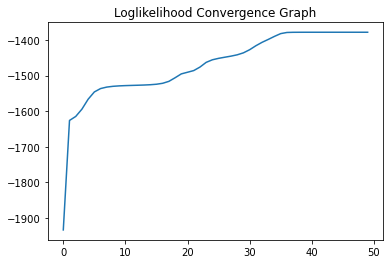

In [4]:
K=4
model = GaussianMixture(gaussians=K, n_iters = 50, tol = 0.0, seed = 4)
#fitted_values = model.fit(X)
mean,weight,covar,probability = model.fit(X)
print("Means",mean)
print("Weights",weight)
print("Covs",covar)
print("Prob",probability)

predicted_values = model.predict(X)

converged iteration: 50


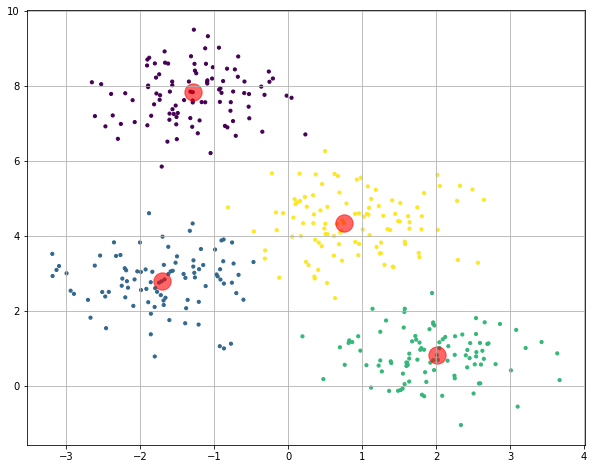

In [5]:
centers = np.zeros((K,2))
for i in range(model.gaussians):
    density = multivariate_normal(cov=model.covs[i], mean=model.means[i]).logpdf(X)
    centers[i, :] = X[np.argmax(density)]
    
plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1],c=predicted_values ,s=10, cmap='viridis')

plt.scatter(centers[:, 0], centers[:, 1],c='Red', s=300, alpha=0.6);
plt.grid()
print('converged iteration:', len(model.log_likelihood_trace))

In [6]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))


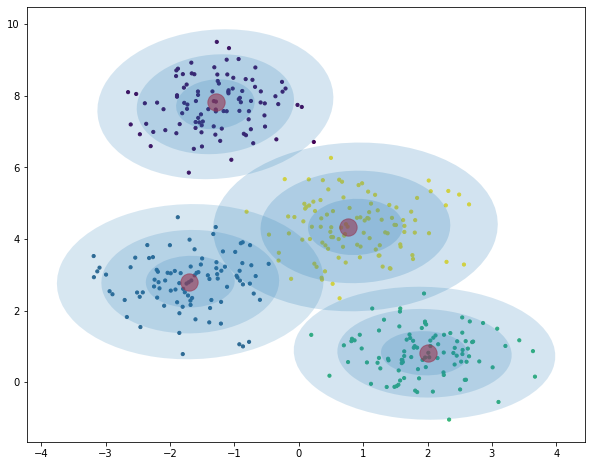

In [7]:
plt.figure(figsize = (10,8))
plt.scatter(X[:, 0], X[:, 1],c=predicted_values ,s=10, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1],c='Red', s=300, alpha=0.6);

w_factor = 0.2 / model.weights.max()
for pos, covar, w in zip(model.means, model.covs, model.weights):
    draw_ellipse(pos, covar, alpha=w * w_factor)


In [8]:
from sklearn import mixture
gmm = mixture.GaussianMixture(n_components = 4, covariance_type = 'full', 
                      max_iter = 600, random_state = 3)

gmm.fit(X)

print('converged or not: ', gmm.converged_)



converged or not:  True


# Validation wrt original GMM 

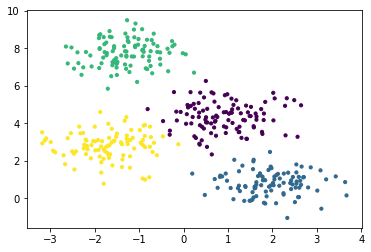

In [9]:

from sklearn import mixture
model = mixture.GaussianMixture(n_components=4, covariance_type='full').fit(Data)
labels = model.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis');